In [1]:
import numpy as np
import gym
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.kernel_approximation import RBFSampler
import matplotlib.pyplot as plt

In [2]:
MAX_ITERS = 10000

In [3]:
class FeatureTransformer:
    def __init__(self, env, RBF_n_components=500):
        
        # set the environment
        self._env = env
        # samples observations from the possible states in the environement
        observation_examples = self.__gen_observation_samples(n=10000)
        # generate a scaler (to scale data)
        self._scaler = self._gen_scaler(samples=observation_examples)
        # generate a featurizer
        self._featurizer = self._gen_featurizer(n=RBF_n_components, samples=observation_examples) 

    def transform(self, observations):
        # first scale the observation
        scaled = self._scaler.transform(observations)
        
        # return featurized representation of the scaled observations
        return self._featurizer.transform(scaled)
        
    def _gen_featurizer(self, n, samples):
        # n: number of monte-carlo samples used to map features of the RBF kernel
        # gamma: Parameter of RBF kernel: exp(-gamma * x^2)
        # https://scikit-learn.org/stable/modules/generated/sklearn.kernel_approximation.RBFSampler.html
        featurizer = FeatureUnion([
            ("rbf1", RBFSampler(gamma=5.0, n_components=n)),
            ("rbf2", RBFSampler(gamma=2.0, n_components=n)),
            ("rbf3", RBFSampler(gamma=1.0, n_components=n)),
            ("rbf4", RBFSampler(gamma=0.5, n_components=n)),
        ])
        # run this once to setup the featurizer
        example_features = featurizer.fit_transform(self._scaler.transform(samples))
        return featurizer
    
    def _gen_scaler(self, samples):
        """
        Create a StandardScaler() based on the samples dataset
        """
        scaler = StandardScaler()
        scaler.fit(samples)

        return scaler
    
    def __gen_observation_samples(self, n=10000):
        
        observation_examples = np.array([self._env.observation_space.sample() for x in range(n)])
        return observation_examples

In [4]:
class Model:
    def __init__(self, env, feature_transformer, learning_rate):
        self._env = env
        self._models = []
        self._feature_transformer = feature_transformer
        self._models = self._initialize_models(n_models=env.action_space.n, learning_rate=learning_rate)
        
    def _initialize_models(self, n_models, learning_rate):
        """
        Initialize models for each action in the env. space:
        # Holds one SGDRegressor for each action
        Use partial_fit() and initialize it with reset state and 0 Gain value.
        """
        models = []
        for i in range(n_models):
            model = SGDRegressor(learning_rate=learning_rate)
            X = self._feature_transformer.transform([self._env.reset()]) # 
            y = [0] # TODO: What is this? Action?
            model.partial_fit(X, y)
            models.append(model)
            
        return models
    
    def predict(self, state):
        X = self._feature_transformer.transform([state])
        result = np.stack([m.predict(X) for m in self._models]).T
        assert(len(result.shape) == 2)

        return result
    
    def update(self, state, action, G):
        """
        Update models given (s,a,G) tuple
        """
        X = self._feature_transformer.transform([state])
        assert(len(X.shape) == 2)
        # TODO: This can be done be a dictionary lookup of action and its value.
        self._models[action].partial_fit(X, [G])

    def sample_action(self, state, eps):
        # Action based on epsilon-greedy algorithm
        if np.random.random() < eps:
            return self._env.action_space.sample()
        else:
            return np.argmax(self.predict(state))

In [5]:
def play_one_episode(model, eps, gamma=0.9):
    observation = model._env.reset()
    done = False
    total_reward = 0
    iters = 0
    while not done and iters < MAX_ITERS:
        action = model.sample_action(observation, eps)
        prev_observation = observation
        observation, reward, done, info = model._env.step(action)
        
        next_ = model.predict(observation)
        # print(next_[0])
        G = reward + gamma*np.max(next_[0])
        model.update(prev_observation, action, G)
        
        total_reward += reward
        iters += 1

    return total_reward

In [6]:
def plot_running_avg(total_rewards):
    N = len(total_rewards)
    running_avg = np.empty(N)
    for t in range(N):
        running_avg[t] = total_rewards[max(0,t-100):(t+1)].mean()
    plt.plot(running_avg)
    plt.title("Running Average")
    plt.show()

In [7]:
env = gym.make('MountainCar-v0')
featT = FeatureTransformer(env)

In [8]:
model = Model(env=env, feature_transformer=featT, learning_rate="constant")

/Users/mmnasr/python-venvs/opencv_python3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [9]:
N_episode = 300
total_rewards = np.empty(N_episode)
for t in range(N_episode):
    eps = 0.1*(0.97**t)
    tot_reward = play_one_episode(model, eps=eps, gamma=0.99)
    total_rewards[t] = tot_reward
    if (t+1) % 10 == 0:
        print("t:{} eps:{} total_reward:{}.".format(t, eps, tot_reward))

/Users/mmnasr/python-venvs/opencv_python3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


t:9 eps:0.07602310586545652 total_reward:-200.0.
t:19 eps:0.05606127246667495 total_reward:-200.0.
t:29 eps:0.041340934901356444 total_reward:-200.0.
t:39 eps:0.03048580282465283 total_reward:-161.0.
t:49 eps:0.02248096653066055 total_reward:-127.0.
t:59 eps:0.016578007115626455 total_reward:-200.0.
t:69 eps:0.012225022422898742 total_reward:-157.0.
t:79 eps:0.009015026486477024 total_reward:-150.0.
t:89 eps:0.00664789803572497 total_reward:-146.0.
t:99 eps:0.0049023204046809935 total_reward:-116.0.
t:109 eps:0.003615089344181072 total_reward:-143.0.
t:119 eps:0.002665854103279885 total_reward:-112.0.
t:129 eps:0.0019658651345404307 total_reward:-148.0.
t:139 eps:0.0014496763804316573 total_reward:-106.0.
t:149 eps:0.0010690263391200145 total_reward:-145.0.
t:159 eps:0.0007883258147532579 total_reward:-104.0.
t:169 eps:0.000581330475653154 total_reward:-106.0.
t:179 eps:0.0004286871184459403 total_reward:-151.0.
t:189 eps:0.0003161242240311002 total_reward:-155.0.
t:199 eps:0.000233117

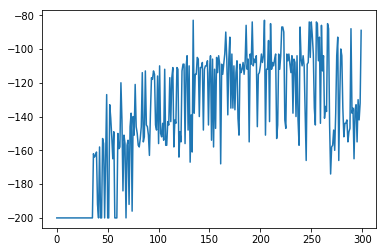

In [10]:
plt.plot(total_rewards)

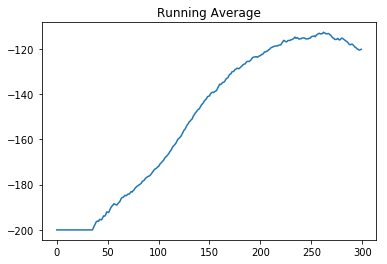

In [11]:
plot_running_avg(total_rewards)